In [1]:
from pmdarima import auto_arima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import useful_functions as uf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
plt.rcParams["figure.figsize"] = (8,4)

In [23]:
# load the data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', )
target_variable = df_raw.columns[0]
df = df_raw[[target_variable]]

# Remove outliers? Define the threshold from 0 to 1 - float
remove_outliers_threshold = np.nan
#remove_outliers_threshold = 0.20

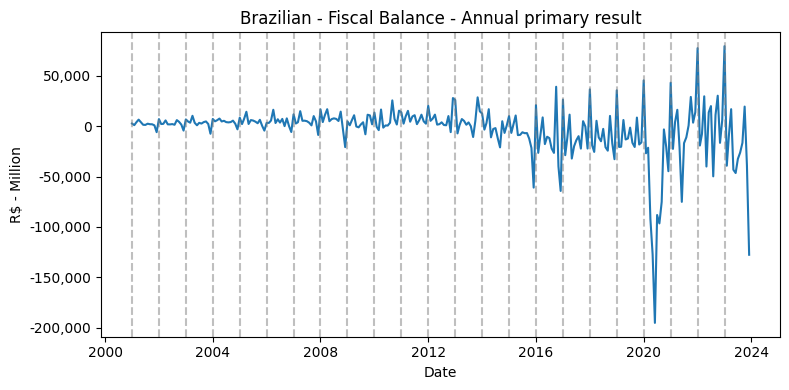

In [24]:
# Let's check the series
# plot the series
fig, ax = plt.subplots()
ax.plot(df[target_variable])
for year in range(df.index.year.min(), df.index.year.max() + 1):
    ax.axvline(pd.Timestamp(year, 1, 1), linestyle='--', color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance - Annual primary result')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) ))


plt.tight_layout()
plt.show()


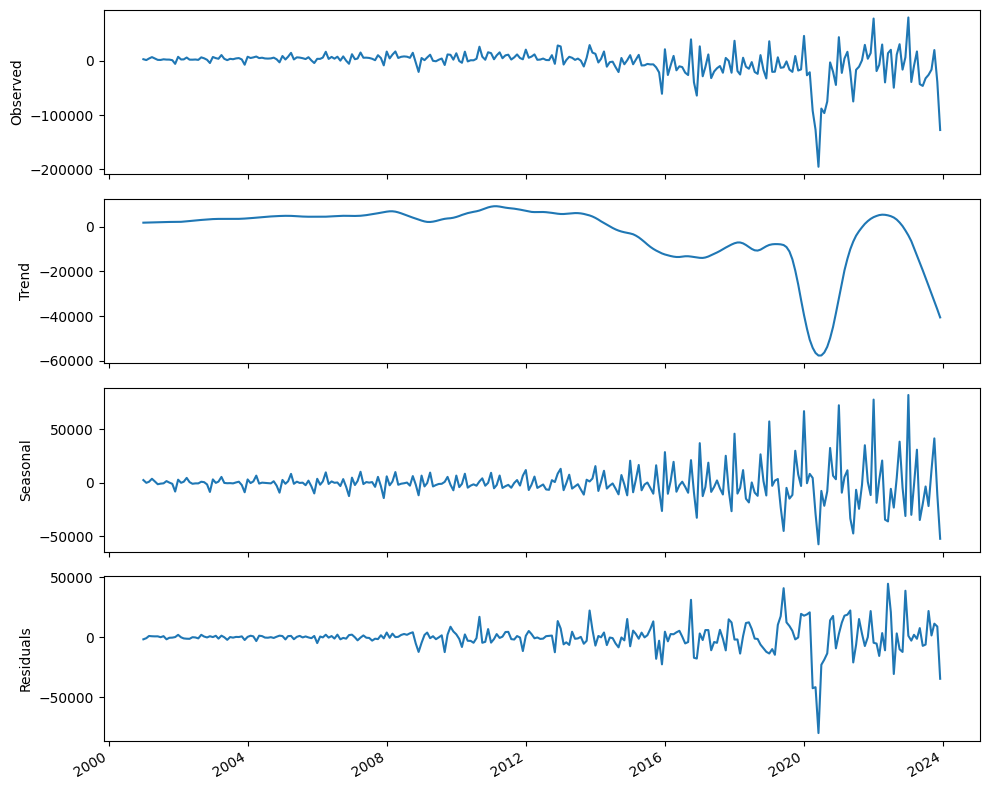

In [25]:
decomposition = STL(df[target_variable], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
# Check if there is any NA value
print(df[target_variable].isna().sum())

0


In [27]:
# If we want to remove outliers
if not pd.isna(remove_outliers_threshold):
    df_to_be_cleaned = df.copy()
    df_cleaned = uf.remove_outliers(df_to_be_cleaned, threshold=remove_outliers_threshold)
else:
    df_cleaned = df.copy()


In [28]:
# Fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [29]:
# Check if there is any NA value
print(df_adjusted[target_variable].isna().sum())

0


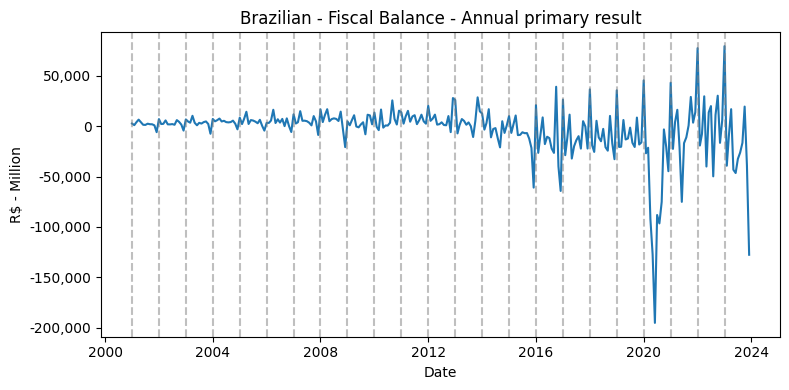

In [30]:
# Let's check the series
# plot the series
fig, ax = plt.subplots()
ax.plot(df_adjusted[target_variable])
for year in range(df_adjusted.index.year.min(), df_adjusted.index.year.max() + 1):
    ax.axvline(pd.Timestamp(year, 1, 1), linestyle='--', color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance - Annual primary result')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) ))


plt.tight_layout()
plt.show()

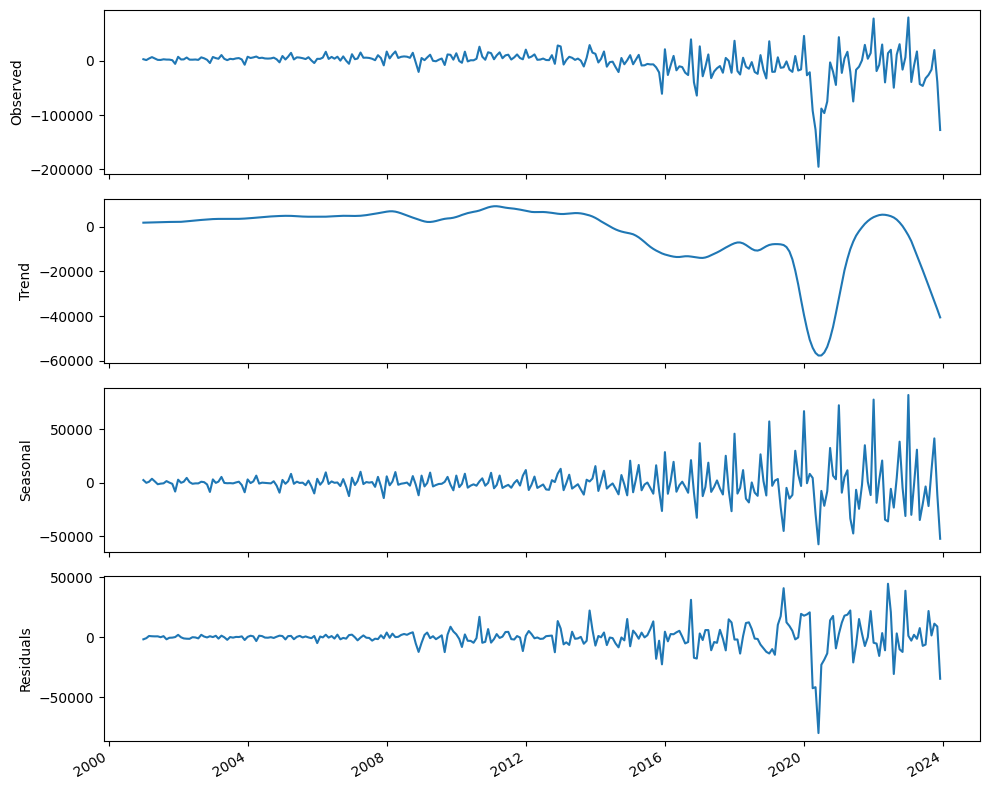

In [31]:
decomposition = STL(df_adjusted[target_variable], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
# Let's check if the series is stationary

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_adjusted.iloc[:,0])
# Print the test statistic and the p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') # if p-value < 0.05, we reject the null hypothesis (H0), the data is stationary

ADF Statistic: -2.5635130302815528
p-value: 0.10077527335316627


In [33]:
# Since the data is not stationary, we need to difference the series twice due to the tren and the seasonality

#df_diff = df_adjusted[target_variable].diff().diff(periods=12).dropna()
df_diff = df_adjusted[target_variable].diff().dropna()
#df_diff = df_adjusted[target_variable].diff(periods=12).dropna()

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -5.972078473377615
p-value: 1.9256139562027315e-07


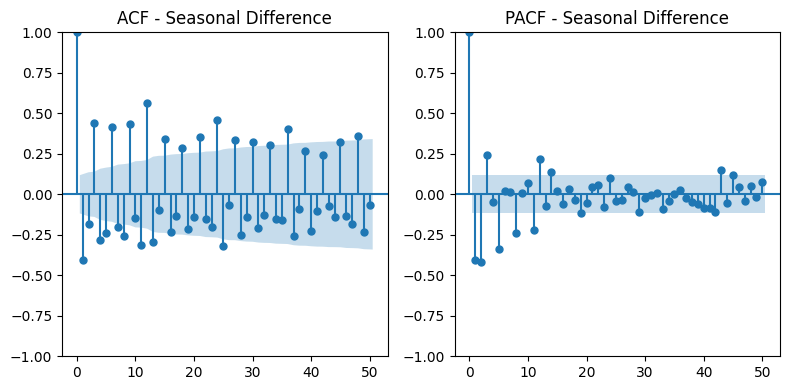

In [34]:
# # Let's plot the ACF and PACF of the differenced series

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot ACF on the first subplot
plot_acf(df_diff, lags=50, ax=axs[0])
axs[0].set_title('ACF - Seasonal Difference')

# Plot PACF on the second subplot
plot_pacf(df_diff, lags=50, ax=axs[1])
axs[1].set_title('PACF - Seasonal Difference')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Define test set 

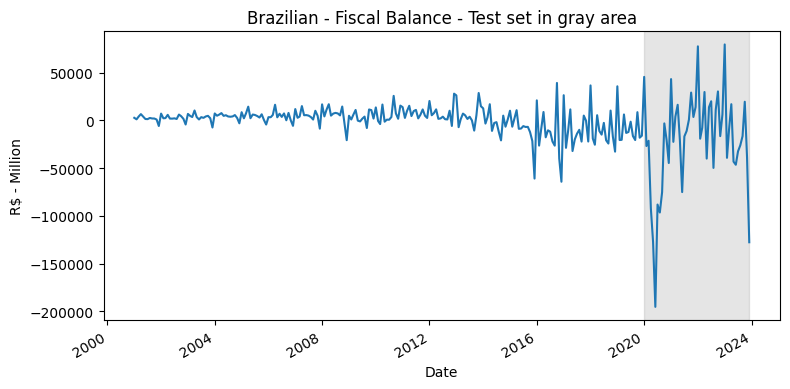

In [35]:
# Define test and validation set sizes
test_size = 48 # months

# Let's print a gray area to represent the test set
fig, ax = plt.subplots()

ax.plot(df_adjusted.index, df_adjusted.iloc[:,0], label='Original')
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance - Test set in gray area')

start_index_test = df_adjusted.index[len(df_adjusted) - test_size]
end_index_test = df_adjusted.index[-1]
# Add a gray area to represent the test set
ax.axvspan(start_index_test, end_index_test, color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [36]:
# Split the data into train and test sets

df_train = df_adjusted[:-test_size]
df_test = df_adjusted[-test_size:]

# df_train.index = pd.date_range(start=df_train.index[0], periods=len(df_train), freq='M')
# df_test.index = pd.date_range(start=df_test.index[0], periods=len(df_test), freq='M')

# df_train.index = df_train.index.to_period('M').to_timestamp() - pd.offsets.MonthBegin(0)
# df_test.index = df_test.index.to_period('M').to_timestamp() - pd.offsets.MonthBegin(0)

In [37]:
# Find the best parameters using auto_arima function
# auto_model = auto_arima(df_train, seasonal=True, m=12, trace=False,
#                         error_action='ignore', suppress_warnings=True)

auto_model = auto_arima(df_train[target_variable], 
                              start_p=0, start_q=0, 
                              max_p=4, max_q=4, 
                              m=12, 
                              start_P=0, start_Q=0, 
                              max_P=4, max_Q=4, 
                              seasonal=True, 
                              d=None, D=1,  
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

# Adjust the model with the best parameters and train it
model = SARIMAX(df_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False, maxiter=200)

# Predict for the test period
predictions = model_fit.forecast(steps=len(df_test))

# Show best parameters
print(auto_model.order)
print(auto_model.seasonal_order)

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

(2, 0, 2)
(0, 1, 1, 12)


In [38]:
# Print the model summary
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:              ECO_fiscal_result_month   No. Observations:                  228
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2285.201
Date:                              Wed, 20 Mar 2024   AIC                           4582.402
Time:                                      15:42:42   BIC                           4602.654
Sample:                                  01-01-2001   HQIC                          4590.584
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1270      0.067      1.896      0.058      -0.004       0.258
ar.L2          0.81

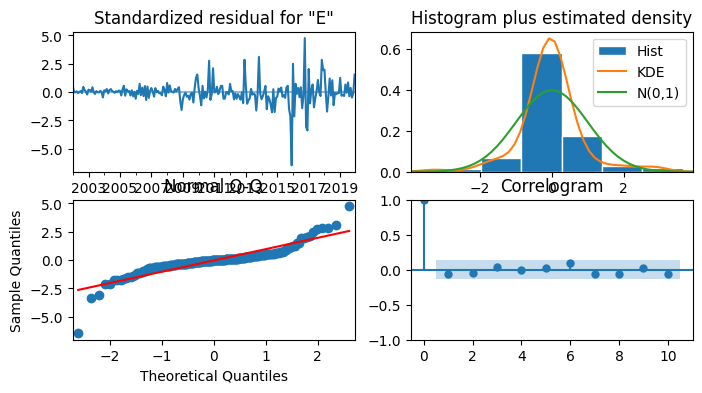

In [39]:
# Let's plot the residuals
model_fit.plot_diagnostics();

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


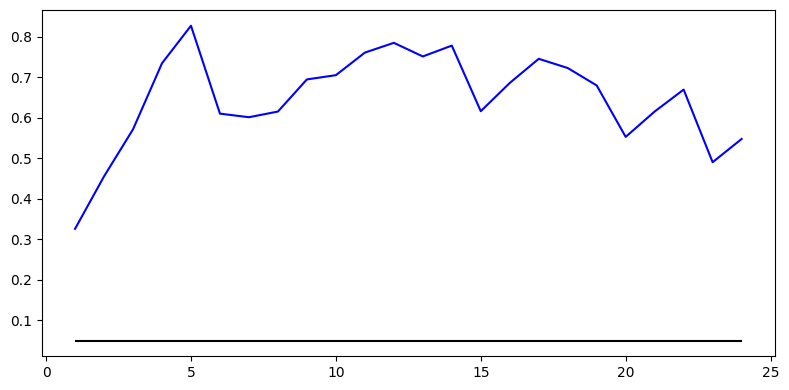

In [40]:
# Define a ljung box test method to check for autocorrelation in the residuals
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black') # Threshold line at 0.05 - p-value significance level
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

# Use ljung box test to check for autocorrelation in the residuals.
residuals = model_fit.resid
# 
ljung_box_test(residuals, True, 12)

In [41]:
# Evaluate the model
#from math import sqrt
mape_SARIMA_auto = mean_absolute_percentage_error(df_test, predictions)
rmse_SARIMA_auto = root_mean_squared_error(df_test, predictions)
mae_SARIMA_auto = mean_absolute_error(df_test, predictions)
print(f'MAPE SARIMA AUTO: {mape_SARIMA_auto:.2f}')
print(f'RMSE SARIMA AUTO: {rmse_SARIMA_auto:.2f}')
print(f'MAE SARIMA AUTO: {mae_SARIMA_auto:.2f}')

MAPE SARIMA AUTO: 1.68
RMSE SARIMA AUTO: 47080.36
MAE SARIMA AUTO: 31319.58


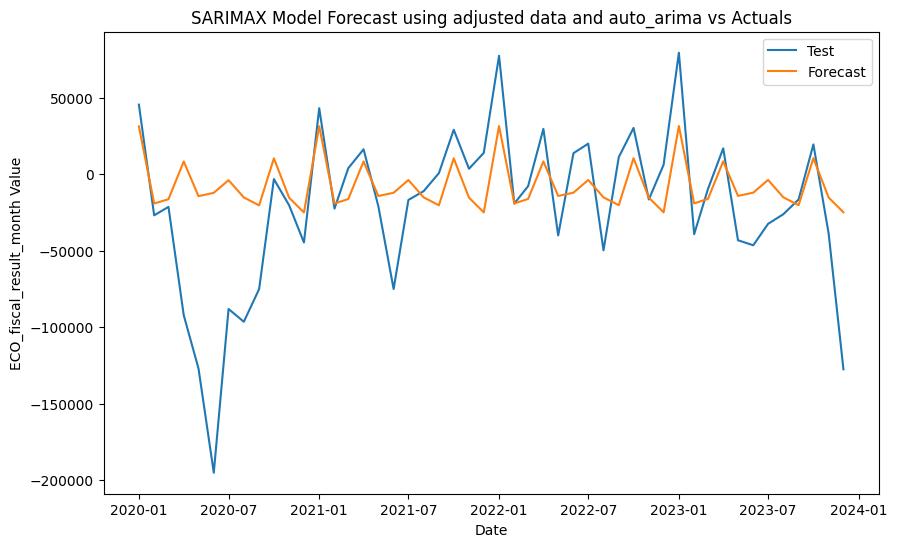

In [42]:
# Plot SARIMAX Model Forecast(auto_arima) vs Actuals

uf.plot_forecast_vs_test(
    target_variable, 
    df_train[target_variable], 
    df_test[target_variable], 
    predictions, 
    'SARIMAX Model Forecast using adjusted data and auto_arima vs Actuals')